# Example Notebook for use of CosMomentum to generate angular power spectrum C_ells, create Gaussian random field sky maps, and configure FLASK for log-normal field simulations (Xavier et al 2016, https://arxiv.org/abs/1602.08503)

In [21]:
# loading required packages
import ctypes
import sys
import numpy as np
import os
import matplotlib.pyplot as plt
import healpy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# we are going to run a c++ code to determine the power spectrum and skewness at the desired cosmological parameters
# first we have to set up the python interface to that code

# compiling and loading c++ library
os.system("cd cpp_code; make DSS")
lib=ctypes.CDLL("./cpp_code/DSS.so")

In [3]:
# initialising a new universe and its matter content
a_initial = 0.000025
a_final = 1.0

# setting up python interface to the c++ code
initialise_new_Universe = lib.initialise_new_Universe
# initialise_new_Universe          (double a_initial,  double a_final,  double Omega_m,  double Omega_b,  double Omega_r,  double Omega_L,  double sigma_8,      double n_s,    double h_100,       double w0,       double w1)
initialise_new_Universe.argtypes = [ ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double]
initialise_new_Universe.restype = None

# Cosmological parameters
Omfid = 0.286  ## matter density in units of critical density 
               ## -- you might want to vary this one between 0.25 and 0.35 or so
Obfid = 0.047  ## density of baryons in units of critical density
hfid = 0.7     ## Hubble parameter in 100km/s/Mpc
nsfid = 0.96   ## spectral index of initial density fluctuations
sig8fid = 0.82 ## sigma_8, standard deviation of relative density in 8h^{-1}Mpc radius spheres as predicted by linear theory
               ## -- you might want to vary this one between 0.7 and 0.9 or so

f_NL = 0.0     ## primordial non-Gaussianity

initialise_new_Universe(a_initial, a_final, Omfid, Obfid, 0.0, 1.0-Omfid, sig8fid, nsfid, hfid, -1.0, 0.0)

In [20]:
# Defining two galaxy samples: One thart serves as "sources" for the lensing, 
#  and one which traces in the matter density that does the lensing ("lenses")
#
# This in the end allows us to generate multiple different density fields in the sky - e.g. one probed by the lensing,
# and one probed by the counts of "lens" galaxies. We won't necessarily need this here - one field is enough for now.

density_sample_1 = 69.47036304452095/(np.pi*30.0**2)
b1_sample_1 = 1.8
b2_sample_1 = 0.0
a0 = 1.26
a1 = 0.28

add_projected_galaxy_sample = lib.add_projected_galaxy_sample
# add_projected_galaxy_sample          (int index_of_universe, const char *n_of_z_file, double density_in_Mpc_over_h_cubed,        double b1,        double b2,       double a0,       double a1)
add_projected_galaxy_sample.argtypes = [         ctypes.c_int,         ctypes.c_char_p,                    ctypes.c_double,  ctypes.c_double,  ctypes.c_double, ctypes.c_double, ctypes.c_double]
add_projected_galaxy_sample.restype = None


return_N_max_projected = lib.return_N_max_projected
# int return_N_max_projected      (int index_of_galaxy_sample, double R_in_Mpc_over_h, double var_NL_rescale)
return_N_max_projected.argtypes = [              ctypes.c_int,        ctypes.c_double,       ctypes.c_double]
return_N_max_projected.restype = ctypes.c_int


change_parameters_of_projected_galaxy_sample = lib.change_parameters_of_projected_galaxy_sample
# change_parameters_of_projected_galaxy_sample          (int index_of_galaxy_sample,        double z, double density_in_Mpc_over_h_cubed,        double b1,        double b2,       double a0,       double a1)
change_parameters_of_projected_galaxy_sample.argtypes = [              ctypes.c_int, ctypes.c_double,                    ctypes.c_double,  ctypes.c_double,  ctypes.c_double, ctypes.c_double, ctypes.c_double]
change_parameters_of_projected_galaxy_sample.restype = None

change_b2_to_minimise_negative_densities_projected = lib.change_b2_to_minimise_negative_densities_projected
# change_b2_to_minimise_negative_densities_projected          (int index_of_galaxy_sample, double R_in_Mpc_over_h, double var_NL_rescale)
change_b2_to_minimise_negative_densities_projected.argtypes = [              ctypes.c_int,        ctypes.c_double,       ctypes.c_double]
change_b2_to_minimise_negative_densities_projected.restype = ctypes.c_double

# Creating first galaxy sample (lenses)
n_of_z_file_str = 'Data/redshift_distributions/pofz_Y1_redMaGiC_bin4.dat'
n_of_z_file = ctypes.c_char_p(n_of_z_file_str.encode('utf-8'))
add_projected_galaxy_sample(0, n_of_z_file, density_sample_1, b1_sample_1, b2_sample_1, a0, a1)

# Creating second galaxy sample (sources)
n_of_z_file_str = 'Data/redshift_distributions/mcal_0.90_1.30_pz.tab'
n_of_z_file = ctypes.c_char_p(n_of_z_file_str.encode('utf-8'))
add_projected_galaxy_sample(0, n_of_z_file, density_sample_1, b1_sample_1, b2_sample_1, a0, a1)

In [8]:

return_R_in_Mpc_over_h_from_angular_scale = lib.return_R_in_Mpc_over_h_from_angular_scale
# return_R_in_Mpc_over_h_from_angular_scale          (int index_of_galaxy_sample, double theta_in_arcmin)
return_R_in_Mpc_over_h_from_angular_scale.argtypes = [              ctypes.c_int,        ctypes.c_double]
return_R_in_Mpc_over_h_from_angular_scale.restype = ctypes.c_double

theta = 30.0
R_2D = return_R_in_Mpc_over_h_from_angular_scale(0, theta)
print(R_2D)

14.998081782418685


In [9]:

configure_FLASK_for_delta_g_and_kappa = lib.configure_FLASK_for_delta_g_and_kappa
# configure_FLASK_for_delta_g_and_kappa          (   int l_max, double theta_in_arcmin,     double bias,        double r, int index_of_lens_sample, int index_of_source_sample, const char *n_of_z_file)
configure_FLASK_for_delta_g_and_kappa.argtypes = [ctypes.c_int,        ctypes.c_double, ctypes.c_double, ctypes.c_double,             ctypes.c_int,               ctypes.c_int,         ctypes.c_char_p]
configure_FLASK_for_delta_g_and_kappa.restype = None

In [12]:
# actually predict angular power spectra and write to a file

l_max = 10000              # largest multipole of C_l written out
theta_in_arcmin = 30.0     # scale on which to compute skewness
bias = 1.0                 # galaxy-matter bias
r = 1.0                    # galaxy-matter correlation coefficient
index_of_lens_sample = 0
index_of_source_sample = 1

output_file_str = 'FLASK_config.tab'
output_file = ctypes.c_char_p(output_file_str.encode('utf-8'))
configure_FLASK_for_delta_g_and_kappa(l_max, theta_in_arcmin, bias, r, index_of_lens_sample, index_of_source_sample, output_file)

In [13]:
# C_gg is the galaxy clustering power spectrum (or matter power spectrum, since bias=1, r=1)
# C_kk is the lensing convergence power spectrum (split in two pieces - just add these)
# C_gk is the cross power-spectrum of the two
!cat FLASK_config.tab

# variances: var_g = 1.21443e-02 ;  cov_gk = 3.06112e-04 ;  var_k_correlated = 8.96469e-06 ;  var_k_uncorrelated = 4.05325e-05
# shift params: lambda_g = 7.30741e-01 ;  lambda_k_correlated = 2.44045e-02 ;  lambda_k_uncorrelated = 5.96034e-02
# ell          C_gg(ell)          C_gk(ell)          C_kk_correlated(ell)          C_kk_uncorrelated(ell)
0    0.00000e+00    0.00000e+00    0.00000e+00    0.00000e+00
1    0.00000e+00    0.00000e+00    0.00000e+00    0.00000e+00
2    1.70772e-06    4.31050e-08    1.50967e-09    3.93634e-08
3    2.99245e-06    7.55244e-08    2.62922e-09    5.63234e-08
4    4.06119e-06    1.02486e-07    3.54601e-09    6.48974e-08
5    4.98817e-06    1.25864e-07    4.32871e-09    6.96960e-08
6    5.80693e-06    1.46508e-07    5.00930e-09    7.21796e-08
7    6.53632e-06    1.64894e-07    5.60622e-09    7.33098e-08
8    7.18874e-06    1.81335e-07    6.13179e-09    7.36577e-08
9    7.77330e-06    1.96063e-07    6.59509e-09    7.33854e-08
10    8.29717e-06    2.09259e-07

5927    2.23203e-08    5.62151e-10    1.59547e-11    5.50286e-11
5928    2.23143e-08    5.61998e-10    1.59502e-11    5.50122e-11
5929    2.23082e-08    5.61845e-10    1.59458e-11    5.49958e-11
5930    2.23021e-08    5.61692e-10    1.59414e-11    5.49795e-11
5931    2.22960e-08    5.61539e-10    1.59369e-11    5.49631e-11
5932    2.22899e-08    5.61386e-10    1.59325e-11    5.49467e-11
5933    2.22839e-08    5.61233e-10    1.59280e-11    5.49304e-11
5934    2.22778e-08    5.61080e-10    1.59236e-11    5.49140e-11
5935    2.22717e-08    5.60928e-10    1.59192e-11    5.48977e-11
5936    2.22657e-08    5.60775e-10    1.59148e-11    5.48813e-11
5937    2.22596e-08    5.60622e-10    1.59103e-11    5.48650e-11
5938    2.22535e-08    5.60470e-10    1.59059e-11    5.48487e-11
5939    2.22475e-08    5.60317e-10    1.59015e-11    5.48324e-11
5940    2.22414e-08    5.60165e-10    1.58971e-11    5.48161e-11
5941    2.22354e-08    5.60013e-10    1.58926e-11    5.47998e-11
5942    2.22293e-08    5.

In [14]:
power_spectra = np.genfromtxt("FLASK_config.tab")

Text(0, 0.5, 'lensing convergence $C_\\ell$')

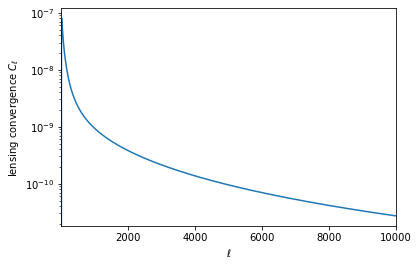

In [27]:
plt.plot(power_spectra[:,0],power_spectra[:,3]+power_spectra[:,4])
plt.yscale("log")
plt.xlim(1,10000)
plt.xlabel(r"$\ell$")
plt.ylabel(r"lensing convergence $C_\ell$")

In [52]:
nside=4 # this is a very coarse map!
cls=power_spectra[:,3]+power_spectra[:,4] # this is the full lensing convergence field's power spectrum

m = healpy.sphtfunc.synfast(cls=cls,pixwin=True,alm=True,nside=nside) 
# this generates a Gaussian random field on the sky with these C_ells

In [53]:
m[0] # this is a list of pixels in the sky, in the healpix 'ring' format

array([-2.85730183e-04,  3.78645027e-04, -1.73975436e-04,  5.98307399e-04,
       -1.00738962e-04,  5.58462321e-04,  7.51739150e-04,  6.79283742e-04,
       -7.16756027e-05,  1.05223163e-03,  7.20745239e-04,  2.21865412e-04,
        3.66553850e-04,  3.51531774e-04,  8.04959226e-04, -6.94550256e-04,
        1.84837557e-04, -1.78036360e-04, -1.90554323e-04,  6.73842473e-04,
       -3.17030350e-04, -6.01935815e-04,  2.81767499e-04, -5.29613112e-04,
        6.16011274e-04, -3.48860259e-04, -7.14967619e-04,  1.05843968e-03,
       -1.41059294e-04,  9.42580841e-05, -1.57455558e-05, -4.66304030e-04,
       -5.55962777e-04,  4.82269467e-05, -1.32200641e-03, -7.20280469e-04,
        5.76678947e-04, -8.56663925e-04,  3.25500053e-04, -5.96235509e-04,
        8.04766310e-04, -2.68616824e-04, -6.60479602e-04,  3.27538481e-04,
        3.27142217e-04,  6.78142491e-04, -2.16183347e-04,  3.53522281e-04,
       -4.67319176e-04, -1.51279417e-04,  3.12061122e-04, -9.48866831e-04,
        7.86772531e-04, -

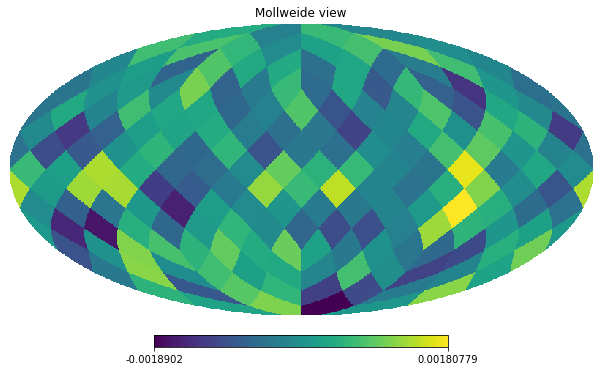

In [54]:
healpy.mollview(m[0]) # convergence in positions in the sky - on a very coarse grid

In [56]:
m[1] # these are the spherical harmonic coefficients of the map 
# (not entirely sure about the ordering ... probably l=0,m=0; then l=1,m=-1;l=1,m=0;l=1,m=1; l=2,...)

array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        9.45699831e-05+0.00000000e+00j,  2.61660474e-04+0.00000000e+00j,
        2.02437330e-04+0.00000000e+00j,  5.24672120e-05+0.00000000e+00j,
       -3.61555325e-04+0.00000000e+00j,  8.44228604e-05+0.00000000e+00j,
        9.72143231e-05+0.00000000e+00j, -4.48410129e-04+0.00000000e+00j,
       -2.25520571e-04+0.00000000e+00j,  1.19599027e-04+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, -1.23566935e-05-5.63454551e-05j,
       -1.19640681e-05+3.83810849e-04j, -5.73478660e-05-2.50541637e-04j,
        1.35637580e-04+2.05749795e-05j, -7.37820701e-05-7.67249421e-05j,
        1.38945525e-04-1.31220590e-04j, -5.85044668e-05-6.78746913e-06j,
        4.08008820e-05+2.09413946e-04j, -5.60735253e-05-2.26043930e-04j,
       -1.00166086e-04+8.16650436e-05j, -1.98115166e-04-1.48532337e-04j,
       -1.43265631e-04+8.89357263e-05j, -2.47581531e-05-1.37757372e-04j,
        9.93871720e-07+1.07374059e-04j,  2.09343026

In [57]:
# trying to reorder from RING to NESTED
m_nested = healpy.pixelfunc.reorder(m[0], inp='RING', out='NESTED')

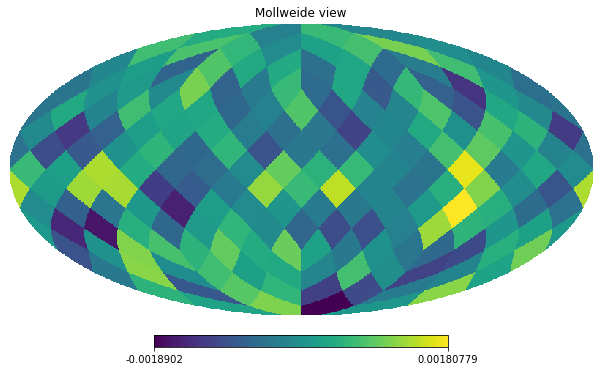

In [59]:
healpy.mollview(m_nested,nest=True) # should look the same as above if the reordering worked